# Sufficient Feature Sets
A sufficient feature set is a set of genes that, when used as features, results in a high accuracy classifier for a state. The genes in a classification group may well be surrogates for transcription modules or programs. This can be exposed by looking for transcription factors common across groups for a single state. This analysis was priimarily conducted in conjunction with the presentation on May, 15, 2020.

# Analysis of Features by Classification Accuracy

In [1]:
import init
import common.constants as cn
import common_python.constants as ccn
from common.trinary_data import TrinaryData
from common.data_provider import DataProvider
import classifier.main_multi_classifier_feature_optimizer as main
from common.data_provider import DataProvider
from common_python.plots import util_plots
from plots import util_plots as xutil_plots

import datetime
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

%matplotlib inline

## Common Data

In [3]:
# These are the "long" data that have individual replications, not averages
PROVIDER = DataProvider()
PROVIDER.do()
TRINARY = TrinaryData(is_averaged=False, is_dropT1=False)  # Trinary data
DF_X = TRINARY.df_X
SER_Y = TRINARY.ser_y
STATES = SER_Y.unique()
path = os.path.join(cn.DATA_DIR, "fit_result.xlsx")
DF_FIT = pd.read_excel(path)
path = os.path.join(cn.DATA_DIR, "fit_result_tf.xlsx")
DF_FIT_TF = pd.read_excel(path)
DF_FIT_TF.head()
TFs = list(DF_FIT_TF["feature"].unique())

In [4]:
PROVIDER.df_trn_signed.head()

,tf,GENE_ID,sign
0,Rv0022c,Rv0029,1
1,Rv0022c,Rv0030,1
2,Rv0022c,Rv0031,1
3,Rv0022c,Rv0069c,1
4,Rv0022c,Rv0070c,1


In [5]:
# Transcription factors
TFS = PROVIDER.df_trn_unsigned[cn.TF].unique()
TFS = list(set(TFS).intersection(TRINARY.df_X.columns))
len(TFS)

96

## Merge Genes With Transcription Factors

In [6]:
df_merge = DF_FIT.merge(PROVIDER.df_trn_unsigned)

In [7]:
df_merge.head()

,state,index,GENE_ID,score,count,tf,sign
0,0,0,Rv2626c,1.0,1,Rv1985c,1
1,0,0,Rv2626c,1.0,1,Rv3133c,1
2,0,1,Rv1813c,1.0,1,Rv1985c,1
3,0,2,Rv0022c,1.0,117,Rv1033c,1
4,0,2,Rv0022c,1.0,117,Rv3597c,1


In [8]:
# Construct a dataframe that merges classification group with transcription factors
df_merge = DF_FIT.merge(PROVIDER.df_trn_unsigned)
del df_merge[cn.SIGN]
del df_merge[cn.COUNT]
df_merge = df_merge.drop_duplicates()
df_merge = df_merge.sort_values([cn.STATE, cn.INDEX, cn.TF])
df_merge.head()

,state,index,GENE_ID,score,tf
0,0,0,Rv2626c,1.0,Rv1985c
1,0,0,Rv2626c,1.0,Rv3133c
2,0,1,Rv1813c,1.0,Rv1985c
8,0,2,Rv3854c,1.0,Rv0324
3,0,2,Rv0022c,1.0,Rv1033c


## Distribution of accuracies in fit results

In [9]:
len(DF_FIT_TF[DF_FIT_TF["state"] == 0])

30

In [19]:
def plotSES(state, df_fit):
    """
    :param int state:
    :param pd.DataFrame df_fit:
      columns
        cn.STATE
        cn.INDEX/cn.GROUP
        cn.GENE_ID/ccn.FEATURE
        cn.SCORE
    """
    df_fit = df_fit.copy()
    if not cn.INDEX in df_fit.columns:
        df_fit[cn.INDEX] = df_fit[cn.GROUP]
    if not cn.GENE_ID in df_fit.columns:
        df_fit[cn.GENE_ID] = df_fit[ccn.FEATURE]
    df = df_fit[df_fit[cn.STATE] == state]
    df = df.copy()
    dfg = df.groupby(cn.INDEX).mean()
    scores = dfg[cn.SCORE].tolist()
    #scores = [f["score"] for _, f in df_fit_result.iterrows() if f["state"] == state]
    scores = sorted(scores, reverse=True)
    xv = range(30)
    plt.scatter(xv, scores[0:len(xv)])
    if state == 0:
        plt.ylabel("accuracy")
    if state % 2 == 1:
        plt.yticks([])
    plt.ylim([0.5, 1])
    #pos = int(0.6*len(scores))
    plt.text(15, 0.6, str(state))
    plt.xticks([])
    # plt.title("State %d" % state)

In [11]:
DF_FIT.head()

,state,index,GENE_ID,score,count
0,0,0,Rv2626c,1.0,1
1,0,1,Rv1813c,1.0,1
2,0,2,Rv0022c,1.0,117
3,0,2,Rv2007c,1.0,117
4,0,2,Rv3854c,1.0,117


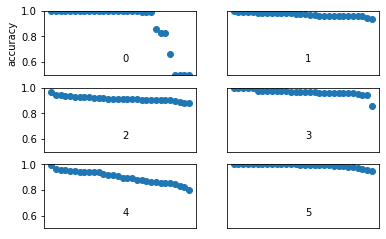

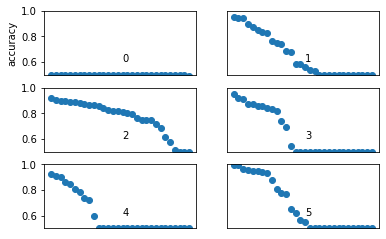

In [21]:
# Analysis of drop in accuracies of CFS for all genes and transcription factors
for df in [DF_FIT, DF_FIT_TF]:
    plt.figure()
    for state in STATES:
        plt.subplot(3, 2, state+1)
        plotSES(state, df)

## Analysis Transcription Factor by State
This analysis examines commonalities in the transcription factors of classification groups.

In [22]:
df_tf = df_merge.copy()
del df_tf[cn.GENE_ID]
df_tf[cn.GROUP] = df_tf[cn.INDEX]
del df_tf[cn.INDEX]
df_tf = df_tf.drop_duplicates()
df_tf.head()

,state,score,tf,group
0,0,1.0,Rv1985c,0
1,0,1.0,Rv3133c,0
2,0,1.0,Rv1985c,1
8,0,1.0,Rv0324,2
3,0,1.0,Rv1033c,2


In [23]:
STATE = 0
df_plot = df_tf[df_tf[cn.STATE] == STATE]
df_plot = df_plot.copy()
df_plot.index = [str(i) for i in df_plot.index]
del df_plot[cn.STATE]
df_plot = df_plot.pivot(index=cn.GROUP, columns=cn.TF, values=cn.SCORE)
df_plot.columns = [str(c) for c in df_plot.columns]
df_plot.head()

,Rv0022c,Rv0023,Rv0042c,Rv0047c,Rv0081,Rv0135c,Rv0302,Rv0324,Rv0353,Rv0465c,...,Rv3249c,Rv3416,Rv3488,Rv3574,Rv3597c,Rv3681c,Rv3736,Rv3830c,Rv3849,Rv3855
group,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
3,NaN,NaN,NaN,0.993333,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df_tf[df_tf[cn.STATE] == state]

,state,score,tf,group
1540,5,0.980000,Rv1423,1
1542,5,0.980000,Rv0047c,2
1543,5,0.980000,Rv0081,2
1544,5,0.980000,Rv0324,2
1545,5,0.980000,Rv0691c,2
...,...,...,...,...
1708,5,0.996667,Rv1033c,29
1709,5,0.996667,Rv1049,29
1710,5,0.996667,Rv2250c,29
1711,5,0.996667,Rv3133c,29


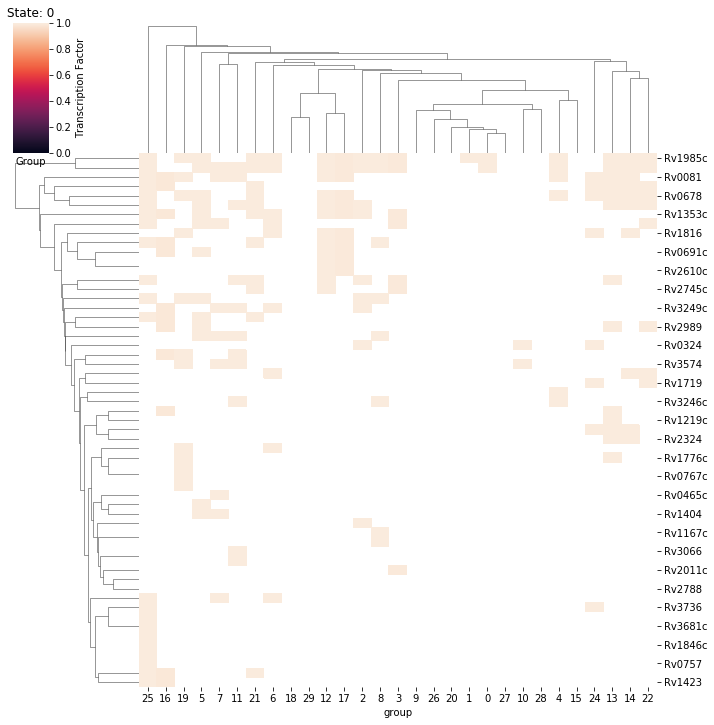

In [25]:
def plotTFByGroup(df_tf, state, min_score=0.9):
    # Construct the data
    df_plot = df_tf[df_tf[cn.STATE] == state]
    df_plot = df_plot.copy()
    del df_plot[cn.STATE]
    df_plot = df_plot.pivot(index=cn.GROUP, columns=cn.TF, values=cn.SCORE)
    df_plot.columns = [str(c) for c in df_plot.columns]
    # Do the plot
    if False:
        plt.figure(figsize=(18, 10))
        ax = plt.gca()
        ax.set_xticks(np.arange(len(df_plot.index))+0.5)
        ax.set_xticklabels(df_plot.index, rotation=0)
        ax.set_yticks(np.arange(len(df_plot.columns))+0.5)
        ax.set_yticklabels(df_plot.columns, rotation=0)
        ax.set_xlabel(cn.GROUP)
        ax.set_ylabel("transcription factor")
        #heatmap = plt.pcolor(df_plot.T)
        #_ = plt.colorbar(heatmap)
    df_plot = df_plot.applymap(lambda v: 0 if np.isnan(v) else v)
    cg = seaborn.clustermap(df_plot.T, row_cluster=True, col_cluster=True, mask=df_plot.T.applymap(lambda v: v <0.9))
    plt.title("State: %d" % state)
    plt.xlabel("Group")
    plt.ylabel("Transcription Factor")
    
plotTFByGroup(df_tf, 0)

## Correlations of Transcription Factors
To identify gene programs, look for correlations among transcription factors by state.

In [27]:
def plotCorr(state):
    indices = SER_Y[SER_Y == state].index
    df_X = DF_X.loc[indices, :]
    util_plots.plotCorr(df_X[TFS], is_yticklabels=True, is_xticklabels=True)

In [28]:
provider = DataProvider()
provider.do()
len(provider.tfs)

102

In [29]:
PROVIDER.df_go_terms.head()

,GENE_ID,GO_Term
0,P9WKY5,host cell nucleus
1,Rv0001,DNA replication initiation---dephosphorylation...
2,Rv0002,extracellular region---cell wall
3,Rv0003,double-strand break repair---cytosol---plasma ...
4,Rv0005,DNA topological change---growth---magnesium io...


In [30]:
genes = ["Rv3417c", "Rv0238"]
df_xpln = PROVIDER.df_go_terms[PROVIDER.df_go_terms[cn.GENE_ID].isin(genes)]
dff = df_xpln.set_index(cn.GENE_ID)
for gene_id in df_xpln[cn.GENE_ID]:
    print("%s: %s" % (gene_id, dff.loc[gene_id, cn.GO_TERM]))

Rv0238: transcription regulatory region sequence-specific DNA binding---DNA-binding transcription factor activity---cytosol---plasma membrane
Rv3417c: 'de novo' protein folding---response to heat---growth---protein refolding---DNA protection---chaperone-mediated protein folding---nucleoid organization---positive regulation of transcription regulatory region DNA binding---single-stranded DNA binding---protein binding involved in protein folding---unfolded protein binding---cell wall---plasma membrane---bacterial nucleoid---GroEL-GroES complex


/home/ubuntu/xstate/common_python/common_python/plots/util_plots.py:127: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cg.fig.show()


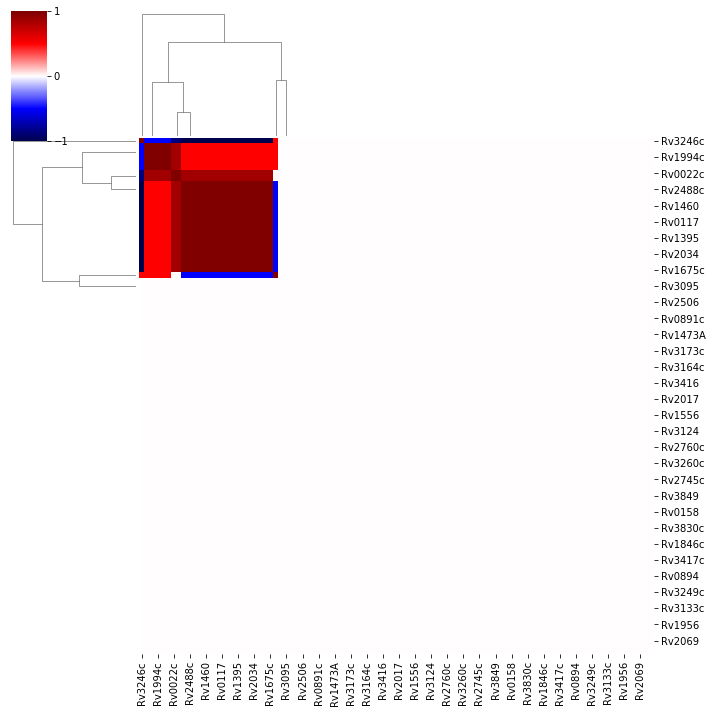

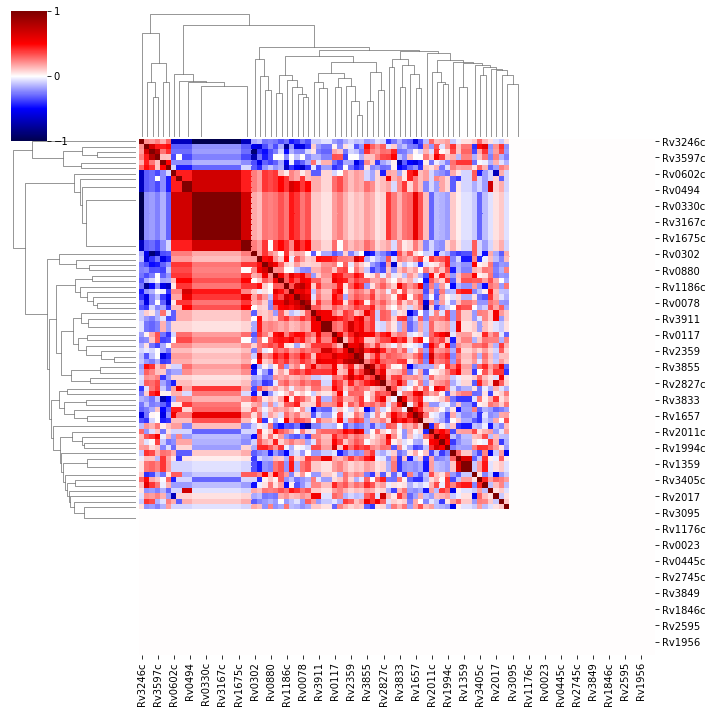

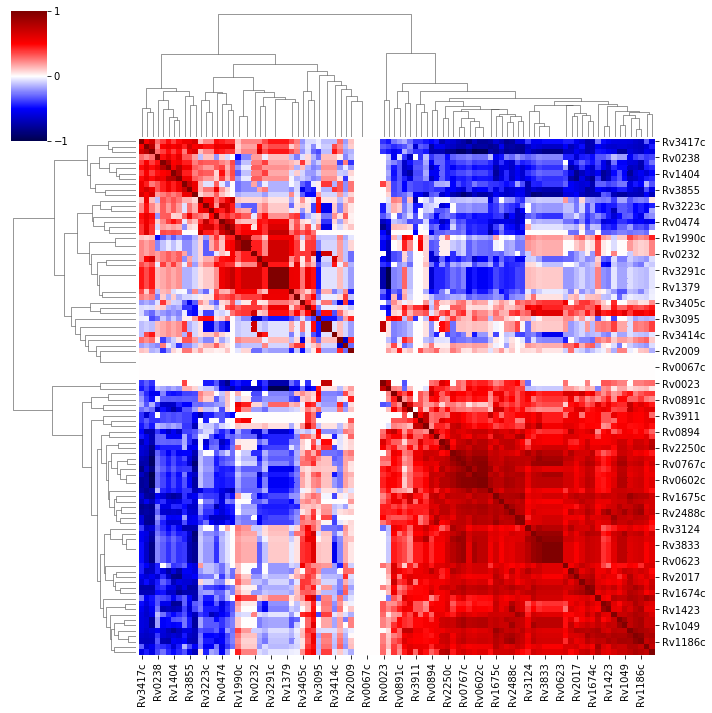

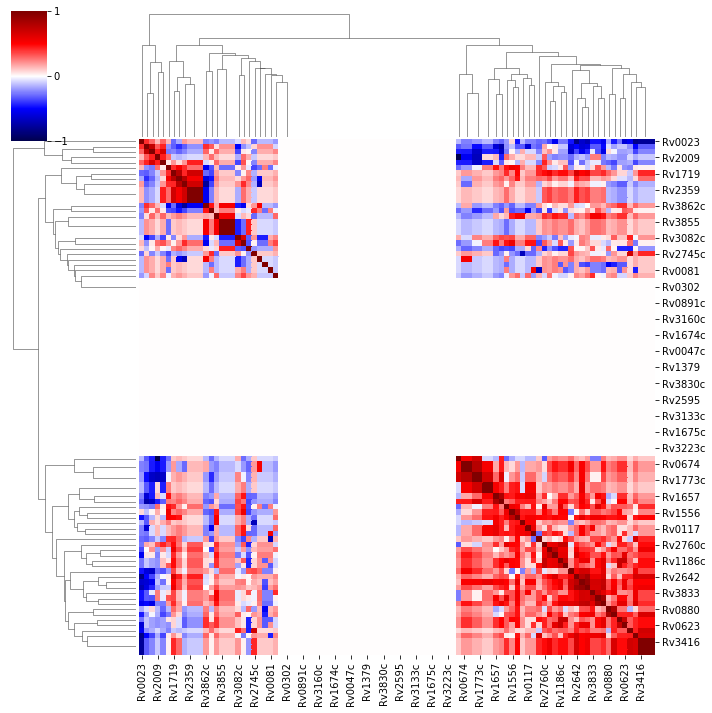

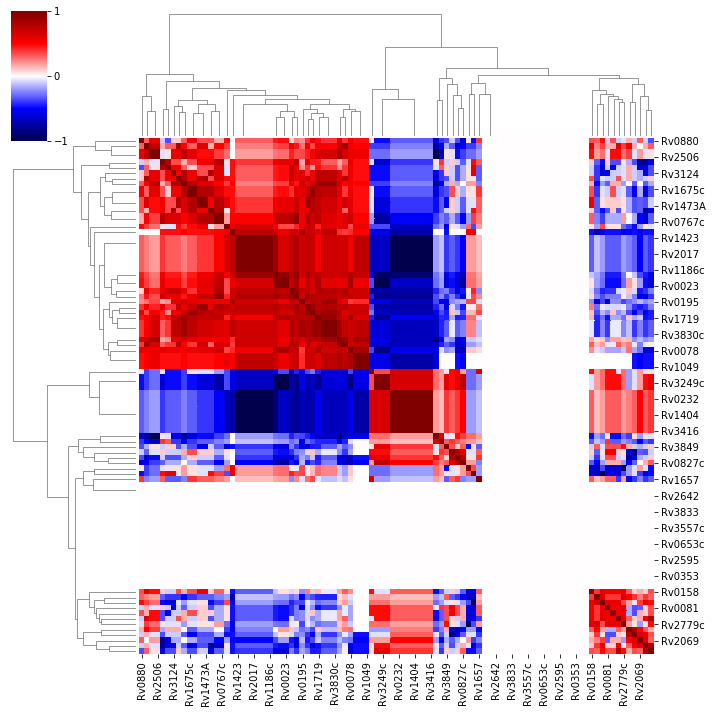

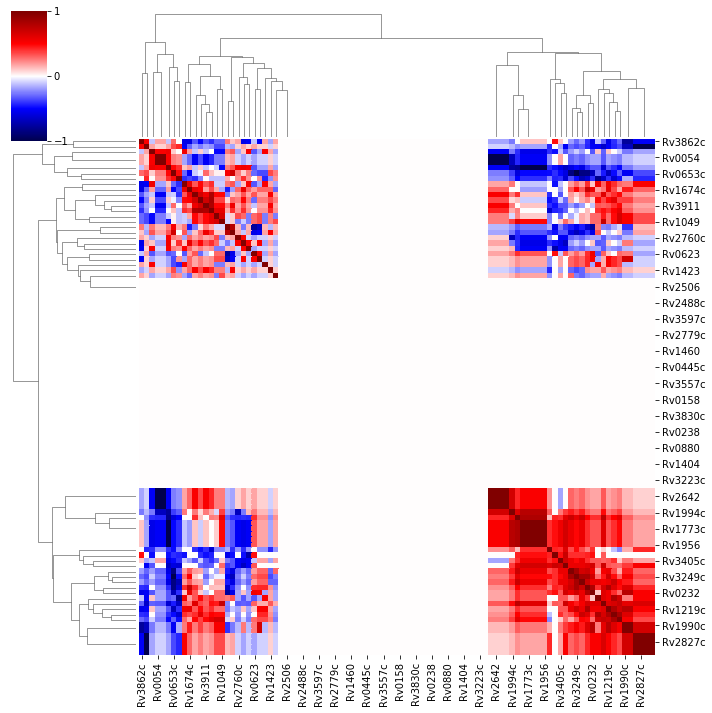

In [32]:
for state in STATES:
    plotCorr(state)

## Analysis of TF Sufficient Feature Sets

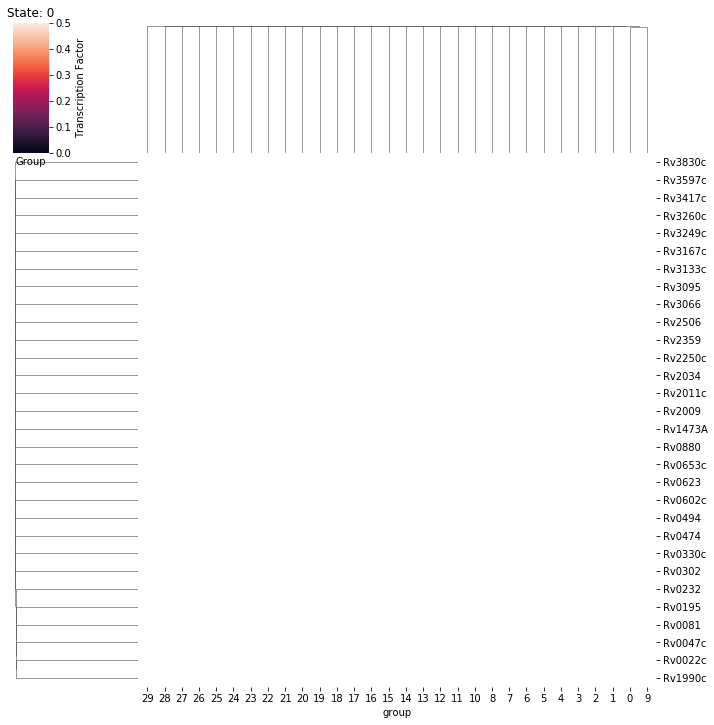

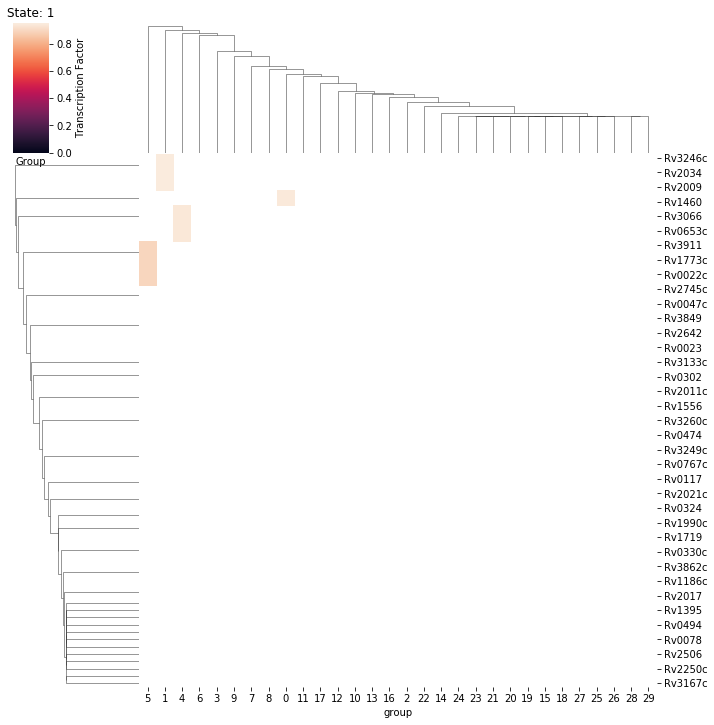

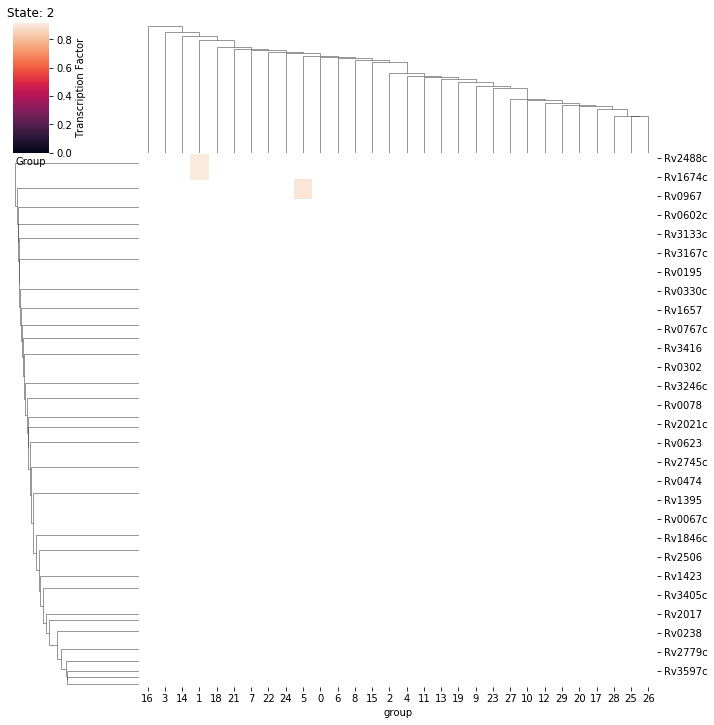

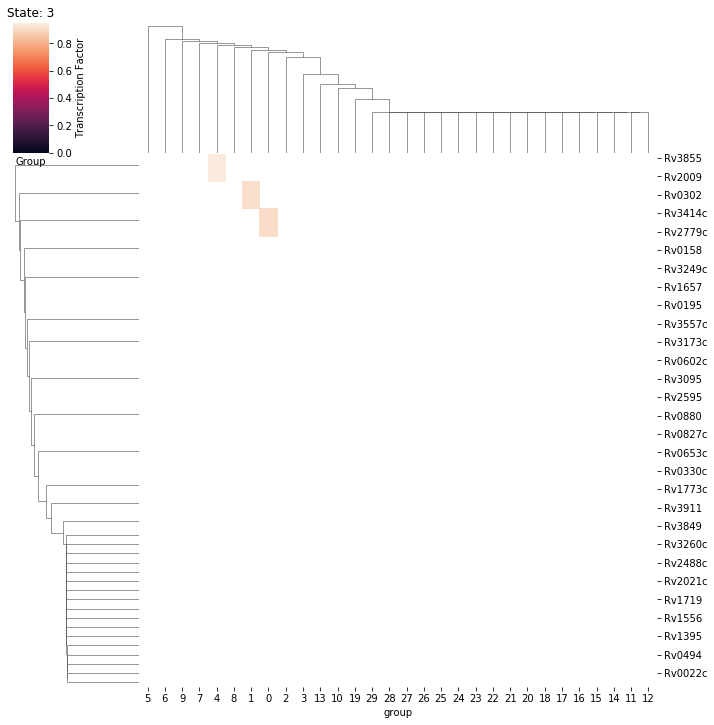

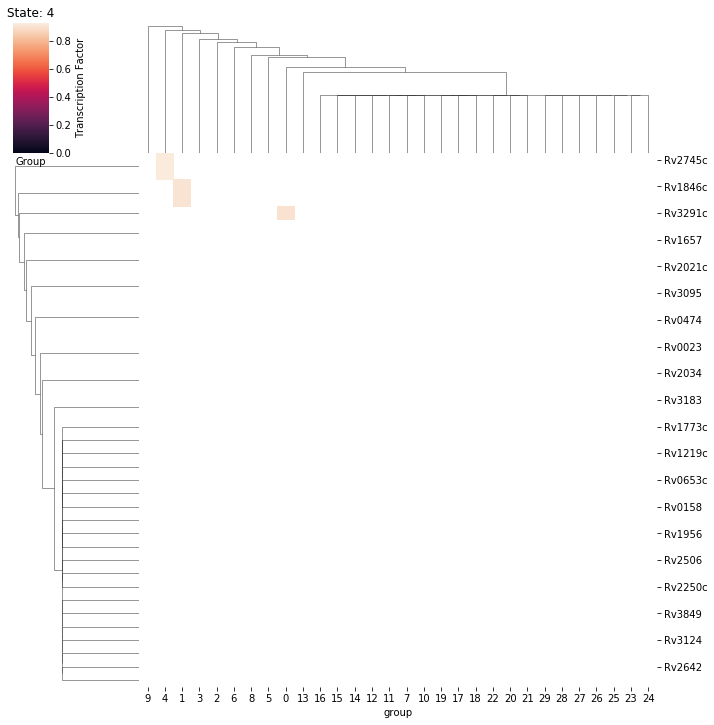

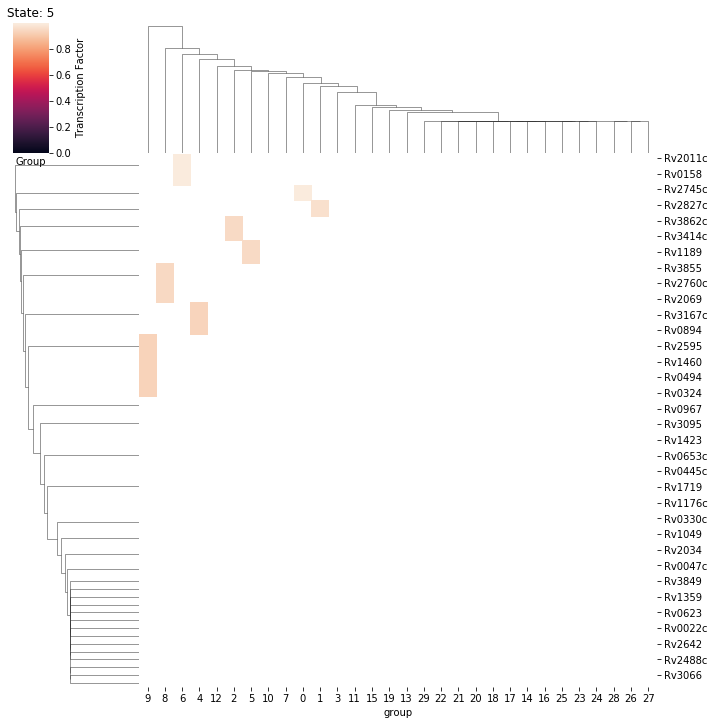

In [35]:
# The following plots indicate the classification set features of TFs that are sufficient to
# distinguish each state.
# By definitions, these are non-overlapping.
df_tf = DF_FIT_TF.copy()
df_tf[cn.TF] = df_tf[ccn.FEATURE]
for state in STATES:
    plotTFByGroup(df_tf, state)

Next steps:
1. Analysis of Eliza's gene
1. Determine if TFs in SFSs are in common correlation groups
1. Observe that TF SFS don't have overlapping members.
1. Construct a correlation matrix of TFs in SFS for each state.
1. TF equvalence analysis.
   1. Given a SFS $S = \{s_{1}, \cdots, s_{n}\}$.
   1. Let $A_S$ be the accuracy of the classifier using the features $S$. Further, let $S-s_m+s = S - \{s_m\} \cup {s}$.
   1. Calculate $max \left ( 0, 1 - \frac{|A_S - A_{S-s_m+s}|}{A_S - A_{S-s_m}} \right )$ for all $S$ and $s \notin S$.
   The SFS-correlation with feature $s_m$ and a feature outside the set $s$ is 1 minus the change in classification accuracy if $s$ is substituted for $s_m$.
   1. An alternative is the fractional increase in accuracy by replacing $s_m$ with $s$. Or, Calculate 
   $\frac{A_{S-s_m+s} - A_S}{A_S - A_{S-s_m}}$

## Special gene analysis

In [ ]:
genes = ["Rv1477", "Rv3717", "Rv0129c" ]

In [ ]:
DF_FIT[DF_FIT[cn.GENE_ID].isin(genes)]

In [ ]:
def getSCSFromDF(state, index):
    df = DF_FIT[DF_FIT[cn.STATE]==state]
    return df[df[cn.INDEX] == index]
 
print(getSCSFromDF(3, 7))
print(getSCSFromDF(5, 21))